In [2]:
import pandas as pd
import numpy as np
from common import helpers

def get_sampling_rate(df):
    # Calculate the difference between consecutive time points and find the mean difference
    df['t_diff'] = df['t'].diff().fillna(0)  # Filling NaN for the first entry with 0 or some appropriate value
    mean_diff = df['t_diff'].mean()  # Mean time difference in microseconds

    # The sampling rate (in Hz) can be estimated as the reciprocal of the mean difference in seconds
    # Since 't' is in microseconds, convert 'mean_diff' to seconds by dividing by 1e6
    sampling_rate = 1 / (mean_diff / 1e6) if mean_diff != 0 else 0
    return sampling_rate

import numpy as np
import pandas as pd

def filter_frequencies(group, sampling_rate, min_freq, max_freq):
    # Apply FFT to transform the time series data to the frequency domain
    fft_data = np.fft.fft(group['t'].values)
    freq = np.fft.fftfreq(len(fft_data), d=1/(sampling_rate * 1e6))
    
    # Create a frequency mask to identify frequencies that are outside the range to keep
    # This mask will be True for frequencies we want to zero out
    mask = (freq > min_freq) & (freq < max_freq) | (freq < -min_freq) & (freq > -max_freq)
    fft_data[mask] = 0  # Apply the mask to zero out unwanted frequencies
    
    # Perform an inverse FFT to transform the data back to the time domain
    filtered_time_series = np.fft.ifft(fft_data)
    
    # Return only the real part of the IFFT output, as the original data is real
    return np.real(filtered_time_series)




In [3]:
infile = input("Raw File: ")
it = helpers.load_evts_from_file(infile)
df = helpers.evts_to_df(it)
sampling_rate = get_sampling_rate(df) * 2 # nyquist
df = df.groupby(['x', 'y', 'p'])

In [26]:
from tqdm import tqdm
from metavision_sdk_core import PeriodicFrameGenerationAlgorithm, ColorPalette
from os import path
import cv2

fps = int(input("fps: "))
outdir = input("output directory: ")
# Explode the 't' column while keeping 'x', 'y', and 'p' associated with each 't' value.
filtered = df.apply(filter_frequencies, sampling_rate=sampling_rate, min_freq=300, max_freq=500)
df_exploded = filtered.reset_index().explode(0).rename(columns = {0: 't'})
it = helpers.DataFrameEventsIterator(df_exploded, max_duration=int(25e6))
frame_gen = PeriodicFrameGenerationAlgorithm(sensor_width=800, sensor_height=600, fps=fps, accumulation_time_us=int(1e6//fps), palette=ColorPalette.Dark)

fourcc = cv2.VideoWriter_fourcc(*'MP4V') 
outfile = path.join(outdir, path.basename(infile)+"_filtered_fourier.mp4")
video_writer = cv2.VideoWriter(outfile, fourcc, fps, (800, 600))

frame_gen.set_output_callback(lambda _, f: video_writer.write(f))

for evs in tqdm(it):
    if evs.size == 0:
        continue
    frame_gen.process_events(evs)

2500it [07:27,  5.58it/s]


In [24]:
video_writer.release()

In [15]:
from importlib import reload
reload(helpers)

<module 'common.helpers' from 'D:\\CZI_scope\\code\\pymodules\\common\\helpers.py'>

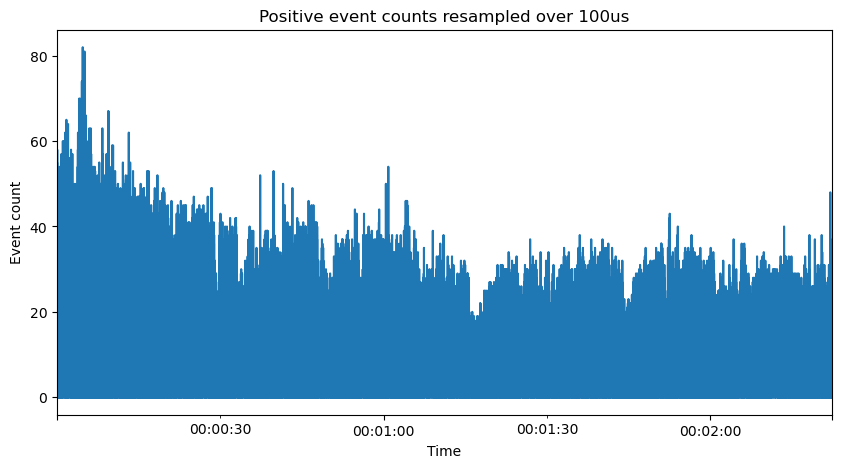

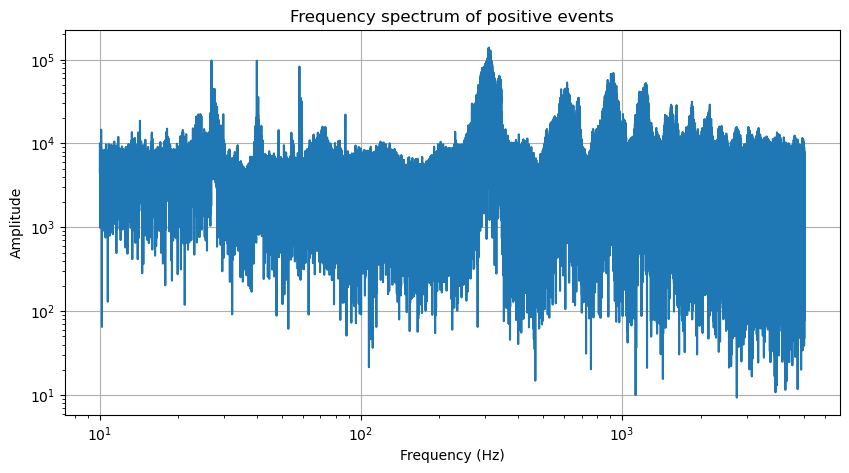

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from common import helpers
from scipy.fft import rfft, rfftfreq

it = helpers.DataFrameEventsIterator(df_exploded)
df = helpers.evts_to_df(it, copy=False)

# Convert to datetime and set index
df['t'] = pd.to_datetime(df['t'], unit='us', origin='unix')
df.set_index('t', inplace=True)
# Filter data by polarity
positive = df[df['p'] == 1]
negative = df[df['p'] == 0]

# Resample and count events in each bin
resample_frequency = '100us'  # Resampling every millisecond; adjust this as needed
positive_counts = positive.resample(resample_frequency).size()
yf = rfft(positive_counts)
xf = rfftfreq(len(positive_counts), pd.Timedelta(resample_frequency).total_seconds())

# Get the index where frequency is greater than 10 Hz
idx = np.where(xf > 10)[0]

# Slice the frequency and amplitude arrays to ignore frequencies below 10 Hz
xf = xf[idx]
yf = yf[idx]

# Plot the resampled event counts
plt.figure(figsize=(10, 5))
positive_counts.plot(title='Positive event counts resampled over ' + resample_frequency)
plt.xlabel('Time')
plt.ylabel('Event count')
plt.show()

# Plot the Fourier transform results
plt.figure(figsize=(10, 5))
plt.loglog(xf, np.abs(yf))
# plt.plot(xf, np.abs(yf))
plt.title('Frequency spectrum of positive events')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
# plt.xticks(np.arange(0, 3e3, 100))
plt.grid(True)
plt.show()

In [2]:
from common import helpers
infile = input("Raw File: ")
it = helpers.load_evts_from_file(infile)
df = helpers.evts_to_df(it)
df.head()

,x,y,p,t
0,620,283,0,6656
1,97,283,0,6656
2,101,283,0,6656
3,622,283,0,6656
4,125,283,0,6656
